# Learning to Rank

In [ ]:
# mount to google drive to get data
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
from sklearn.datasets import load_svmlight_file
from sklearn.metrics import ndcg_score
import numpy as np
import pandas as pd

# Load the dataset for one fold
def load_one_fold(data_path):
    X_train, y_train, qid_train = load_svmlight_file(str(data_path + 'train.txt'), query_id=True)
    X_test, y_test, qid_test = load_svmlight_file(str(data_path + 'test.txt'), query_id=True)
    X_valid, y_valid, qid_valid = load_svmlight_file(str(data_path + 'vali.txt'), query_id=True)
    y_train = y_train.astype(int)
    y_test = y_test.astype(int)
    _, group_train = np.unique(qid_train, return_counts=True) # counts of the unique values
    _, group_test = np.unique(qid_test, return_counts=True) # counts of the unique values
    _, group_valid = np.unique(qid_valid, return_counts=True) # counts of the unique values
    return X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid

def ndcg_single_query(y_score, y_true, k):
    order = np.argsort(y_score)[::-1]
    y_true = np.take(y_true, order[:k])

    gain = 2 ** y_true - 1

    discounts = np.log2(np.arange(len(y_true)) + 2)
    return np.sum(gain / discounts)

# calculate NDCG score given a trained model
def compute_ndcg_all(model, X_test, y_test, qids_test, k=10):
    unique_qids = np.unique(qids_test)
    ndcg_ = list()
    for i, qid in enumerate(unique_qids):
        y = y_test[qids_test == qid]

        if np.sum(y) == 0:
            continue

        p = model.predict(X_test[qids_test == qid])

        idcg = ndcg_single_query(y, y, k=k)
        ndcg_.append(ndcg_single_query(p, y, k=k) / idcg)
    return np.mean(ndcg_)

# get importance of features
# def get_feature_importance(model, importance_type='gain'):
#     return model.booster_.feature_importance(importance_type=importance_type)
def get_feature_importance(model, reduced_indices=None, importance_type='gain'):

    if reduced_indices:
      feature_order = reduced_indices
    else:
      feature_order = model.feature_name()

    importance_df = (
        pd.DataFrame({
            'feature_name': feature_order,
            'importance_gain': model.feature_importance(importance_type='gain'),
            'importance_split': model.feature_importance(importance_type='split'),
        })
        .sort_values('importance_gain', ascending=False)
        .reset_index(drop=True)
    )
    return importance_df

## QUESTION 13: Data Understanding and Preprocessing


* Loading and pre-processing Web10k data.
* Print out the number of unique queries in total and show distribution of relevance labels



In [ ]:
fold = 1
data_path = '/content/drive/MyDrive/UCLA Course/Winter 2024/ECE 219/Project3-Recommender Systems/MSLR-WEB10K'
X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid = load_one_fold(data_path + '/Fold'+str(fold)+'/')

In [ ]:
# calculate the number of unique queries
unique_qids = np.unique(np.concatenate((qid_train, qid_test, qid_valid)))
num_unique_queries = len(unique_qids)
print(f"Number of unique queries: {num_unique_queries}")

Number of unique queries: 10000


Distribution of relevance labels (consider train/test/valid):
Label 0: 624263
Label 1: 386280
Label 2: 159451
Label 3: 21317
Label 4: 8881


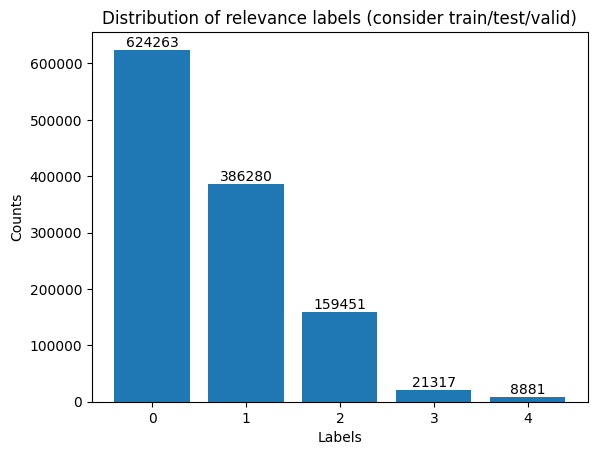

In [ ]:
import matplotlib.pyplot as plt

# show distribution of relevance labels
all_labels = np.concatenate((y_train, y_test, y_valid))
labels, counts = np.unique(all_labels, return_counts=True)
label_distribution = {label: counts[i] for i, label in enumerate(labels)}

print(f"Distribution of relevance labels (consider train/test/valid):")
for label, count in label_distribution.items():
    print(f"Label {int(label)}: {count}")

# plot the distribution
plt.bar(label_distribution.keys(), label_distribution.values())

for k, v in label_distribution.items():
  plt.text(k, v, v, ha = 'center', va = 'bottom')

plt.xlabel("Labels")
plt.ylabel("Counts")
plt.title("Distribution of relevance labels (consider train/test/valid)")
plt.show()

## QUESTION 14 & QUESTION 15

### QUESTION 14: LightGBM Model Training
For each of the five provided folds, train a LightGBM model using the `lambdarank` objective. After training, evaluate and report the model’s performance on the test set using nDCG@3, nDCG@5 and nDCG@10.

Answer:

| nDCG | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|  -------- | -------- | -------- | -------- | -------- | -------- |
| nDCG@3 | 0.4446 | 0.4487 | 0.4425 | 0.4514 | 0.4607 |
| nDCG@5 | 0.4546 | 0.4521 | 0.4509 | 0.4588 | 0.4649 |
| nDCG@10 | 0.4702  | 0.4675 | 0.4692 | 0.4791 | 0.4842 |


---


### QUESTION 15: Result Analysis and Interpretation

For each of the five provided folds, list top 5 most important features of the model based on the importance score. Use importance_type='gain'.

Answer:

| No. | Fold 1 | Fold 2 | Fold 3 | Fold 4 | Fold 5 |
|  -------- | -------- | -------- | -------- | -------- | -------- |
| 1 | Column_133 | Column_133 |Column_133 | Column_133 | Column_133 |
| 2 | Column_7  | Column_107 | Column_107 | Column_54 | Column_54 |
| 3 | Column_54   | Column_54 |  Column_54 | Column_107 | Column_7 |
| 4 | Column_107  | Column_129  | Column_129 | Column_129 | Column_107 |
| 5 | Column_129 | Column_7  | Column_7 | Column_128 | Column_128 |

In [ ]:
!pip install lightgbm

In [ ]:
import lightgbm as lgb

def train_and_evaluate_one_fold_with_validation(data_path, X_train, y_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid):

  # prepare train, valid, test datasets
  train_data = lgb.Dataset(X_train, label=y_train, group=group_train, free_raw_data=False)
  valid_data = lgb.Dataset(X_valid, label=y_valid, group=group_valid, free_raw_data=False)
  test_data = lgb.Dataset(X_test, label=y_test, group=group_test, free_raw_data=False, reference=train_data)

  # parameters for LightGBM
  params = {
      'objective': 'lambdarank',
      'metric': 'ndcg',
      'ndcg_eval_at': [3, 5, 10],
      'learning_rate': 0.05,
      'num_leaves': 31,
      'verbose': -1
  }

  # train the model
  num_boost_round = 100
  lgb.cv(params, train_data, num_boost_round, nfold=5) # cv
  gbm = lgb.train(params, train_data, num_boost_round, valid_sets=[valid_data], callbacks=[lgb.early_stopping(stopping_rounds=10)])

  # evaluate the model
  print('\nModel performance on the test set (nDCG@3, nDCG@5, nDCG@10):')
  for k in [3, 5, 10]:
    ndcg_scores = compute_ndcg_all(gbm, X_test, y_test, qid_test, k)  # adjust this for k=3, 5, 10
    print(f'k = {k}, testing ndcg score: {ndcg_scores}')

  return gbm

def plot_feature_importance(gbm, fold):
  # feature importance
  feature_importance = get_feature_importance(gbm)
  print(f'\nTop 5 feature importance in Fold{fold}:\n{feature_importance.head(5)}\n')

  # plot top 5 most important features
  lgb.plot_importance(gbm, importance_type='gain', max_num_features=5, title=f'Top 5 Feature Importance in Fold{fold}', grid=False)
  plt.show()


============= Fold1 =============
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[73]	valid_0's ndcg@3: 0.473367	valid_0's ndcg@5: 0.476424	valid_0's ndcg@10: 0.493763

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.44456992515667343
k = 5, testing ndcg score: 0.45456467531943034
k = 10, testing ndcg score: 0.4701929292191055

Top 5 feature importance in Fold1:
  feature_name  importance_gain  importance_split
0   Column_133     50777.120073               103
1     Column_7     10627.043671                30
2    Column_54      7601.705648                27
3   Column_107      6624.363126               130
4   Column_129      6128.589797               114



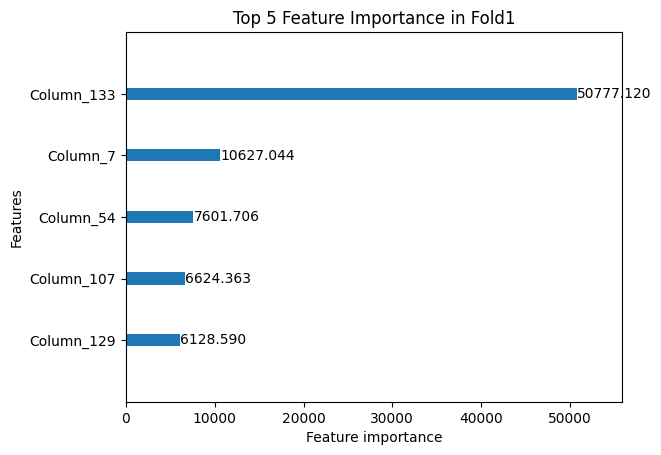


============= Fold2 =============
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[75]	valid_0's ndcg@3: 0.462326	valid_0's ndcg@5: 0.469716	valid_0's ndcg@10: 0.488841

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.44874691316801657
k = 5, testing ndcg score: 0.4520912281087201
k = 10, testing ndcg score: 0.46754763319425136

Top 5 feature importance in Fold2:
  feature_name  importance_gain  importance_split
0   Column_133     50500.734923                98
1   Column_107     11151.335602               157
2    Column_54      8119.935635                37
3   Column_129      7040.350111               143
4     Column_7      6887.684011                22



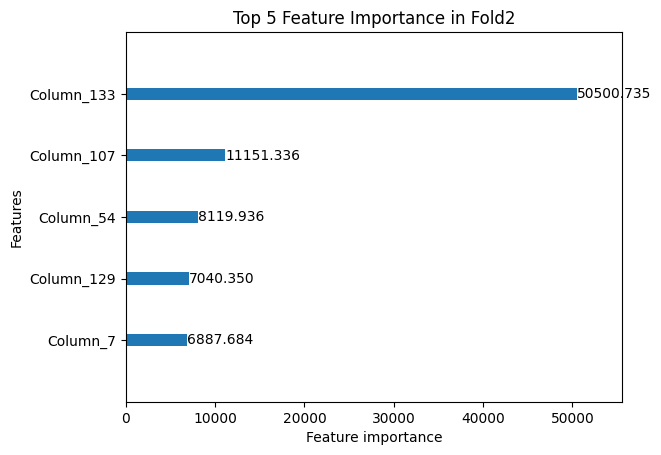


============= Fold3 =============
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's ndcg@3: 0.474074	valid_0's ndcg@5: 0.476085	valid_0's ndcg@10: 0.492215

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.44251536463540597
k = 5, testing ndcg score: 0.4508952689136397
k = 10, testing ndcg score: 0.46923858038012356

Top 5 feature importance in Fold3:
  feature_name  importance_gain  importance_split
0   Column_133     50574.326808               103
1    Column_54     11866.200945                34
2   Column_107      9030.951607               144
3   Column_129      7123.230594               179
4   Column_128      6921.748647               179



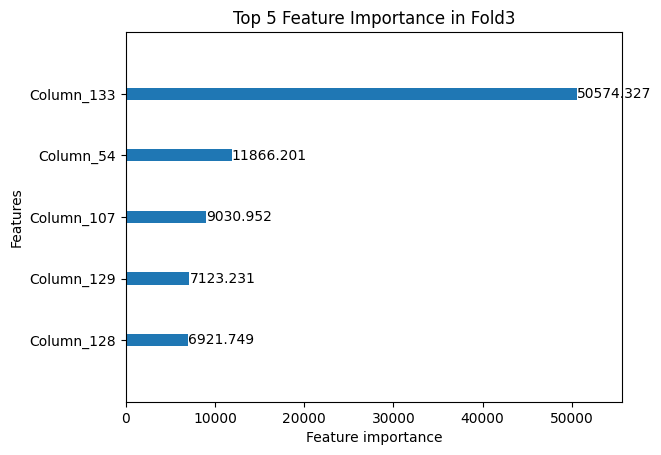


============= Fold4 =============
Training until validation scores don't improve for 10 rounds
Early stopping, best iteration is:
[87]	valid_0's ndcg@3: 0.458525	valid_0's ndcg@5: 0.464746	valid_0's ndcg@10: 0.48288

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.4513869012433184
k = 5, testing ndcg score: 0.45881548888493456
k = 10, testing ndcg score: 0.47908493872692465

Top 5 feature importance in Fold4:
  feature_name  importance_gain  importance_split
0   Column_133     51262.309673               103
1    Column_54      9154.632476                29
2     Column_7      8149.698136                23
3   Column_107      7553.270632               136
4   Column_128      6149.309267               156



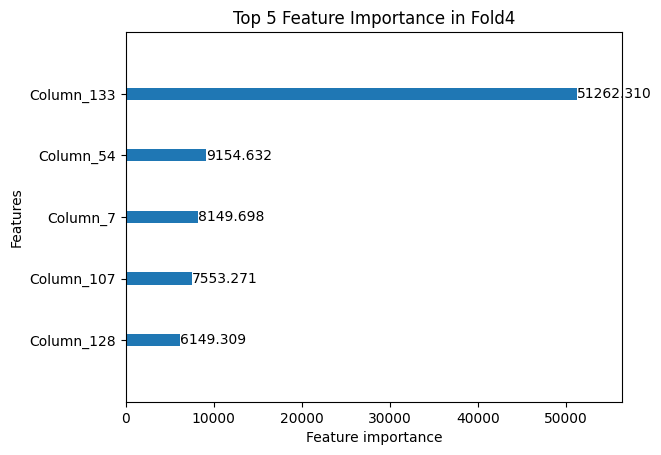


============= Fold5 =============
Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's ndcg@3: 0.471239	valid_0's ndcg@5: 0.477973	valid_0's ndcg@10: 0.496325

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.4607164493091444
k = 5, testing ndcg score: 0.46491858097212796
k = 10, testing ndcg score: 0.48418702980777395

Top 5 feature importance in Fold5:
  feature_name  importance_gain  importance_split
0   Column_133     50762.697981               113
1     Column_7     12024.163998                23
2    Column_54      7674.576921                38
3   Column_107      6544.460454               136
4   Column_128      6142.607745               174



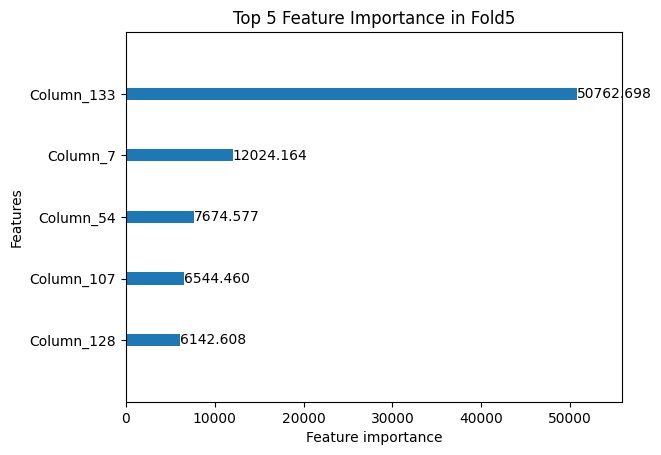

In [ ]:
data_path = '/content/drive/MyDrive/UCLA Course/Winter 2024/ECE 219/Project3-Recommender Systems/MSLR-WEB10K'

for fold in range(1, 6):
  print(f'\n============= Fold{fold} =============')
  # load one fold data
  X_train, y_train, qid_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid = load_one_fold(data_path + '/Fold'+str(fold)+'/')
  # train and evaluate model
  gbm = train_and_evaluate_one_fold_with_validation(data_path, X_train, y_train, group_train, X_test, y_test, qid_test, group_test, X_valid, y_valid, qid_valid, group_valid)
  plot_feature_importance(gbm, fold)

## QUESTION 16: Experiments with Subset of Features
### 16-1 Remove top 20
Remove **the top 20** most important features according to the computed importance score in the question 15. Then train a new LightGBM model on the resulted 116 dimensional query-url data. Evaluate the performance of this new model on the test set using nDCG. Does the outcome align with your expectations? If not, please share your hypothesis regarding the potential reasons for this discrepancy.

Answer:

- The model performance on testing dataset of nDCG@3, nDCG@5, and nDCG@10 are:
  - k = 3, testing ndcg score: 0.3843961691376027
  - k = 5, testing ndcg score: 0.3924111354260531
  - k = 10, testing ndcg score: 0.41529167826546537
- As anticipated, there was a decline in model performance compared to the original 136-feature model. This outcome was expected due to the removal of the 20 most significant features, which likely contributed essential information for the model's prediction accuracy.

In [ ]:
get_feature_importance(gbm)[:20] # show to 20 features

In [ ]:
# get top 20 features
important_feature_indices = [int(i.split('_')[-1]) for i in get_feature_importance(gbm)[:20]['feature_name'].tolist()]
reduced_indices = [i for i in range(136) if i not in important_feature_indices]

# remove top 20 features
if X_train[:, reduced_indices].shape[1] == 116:
  X_train_reduced = X_train[:, reduced_indices]
  X_test_reduced = X_test[:, reduced_indices]
  X_valid_reduced = X_valid[:, reduced_indices]
  print(X_train_reduced.shape, X_test_reduced.shape, X_valid_reduced.shape)

(722602, 116) (235259, 116) (242331, 116)


In [ ]:
# train model with reduced features
gbm_remove_top_20 = train_and_evaluate_one_fold_with_validation(data_path, X_train_reduced, y_train, group_train, X_test_reduced, y_test, qid_test, group_test, X_valid_reduced, y_valid, qid_valid, group_valid)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[99]	valid_0's ndcg@3: 0.401609	valid_0's ndcg@5: 0.41011	valid_0's ndcg@10: 0.427587

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.3843961691376027
k = 5, testing ndcg score: 0.3924111354260531
k = 10, testing ndcg score: 0.41529167826546537


In [ ]:
# top 5 features
get_feature_importance(gbm_remove_top_20, reduced_indices)[:5]

,feature_name,importance_gain,importance_split
0,52,16854.846956,30
1,135,9422.539188,179
2,10,8139.244966,230
3,63,6224.195507,69
4,58,5092.515440,182



Top 5 feature importance in Fold5:
  feature_name  importance_gain  importance_split
0    Column_46     16854.846956                30
1   Column_115      9422.539188               179
2     Column_9      8139.244966               230
3    Column_56      6224.195507                69
4    Column_51      5092.515440               182



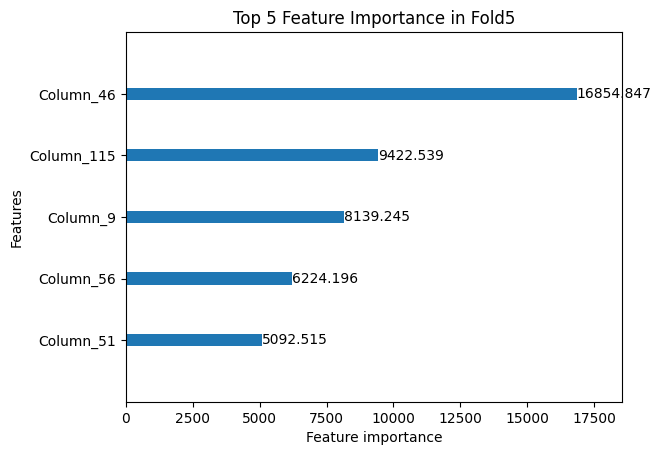


Top 5 features in original feature order: (52, 135, 10, 63, 58)


In [ ]:
# show new feature importance
plot_feature_importance(gbm_remove_top_20, 5)

# Map Top 5 features into the original feature order
print(f'\nTop 5 features in original feature order: {reduced_indices[46], reduced_indices[115], reduced_indices[9], reduced_indices[56], reduced_indices[51]}')

### 16-2 Remove least 60
Remove **the 60 least** important features according to the computed importance score in the question 15. Then train a new LightGBM model on the resulted 76 dimensional query-url data. Evaluate the performance of this new model on the test set using nDCG. Does the outcome align with your expectations? If not, please share your hypothesis regarding the potential reasons for this discrepancy.

Answer:

- The model performance on testing dataset of nDCG@3, nDCG@5, and nDCG@10 are:
  - k = 3, testing ndcg score: 0.4583990018460936
  - k = 5, testing ndcg score: 0.4659233889614642
  - k = 10, testing ndcg score: 0.4847601836863461
-  This slight improvement in model performance compared to the original 136-feature model was aligned with my expectations. The enhancement can be attributed to the elimination of the least significant features, which may have been causing noise in the model. Removing the unnecessary useless information probably simplifies the dataset for more effective learning and prediction.



In [ ]:
get_feature_importance(gbm)[-60:] # show least 60 features

In [ ]:
# get least 60 features
important_feature_indices = [int(i.split('_')[-1]) for i in get_feature_importance(gbm)[-60:]['feature_name'].tolist()]
reduced_indices = [i for i in range(136) if i not in important_feature_indices]

# remove least 60 features
if X_train[:, reduced_indices].shape[1] == 136-60 :
  X_train_reduced = X_train[:, reduced_indices]
  X_test_reduced = X_test[:, reduced_indices]
  X_valid_reduced = X_valid[:, reduced_indices]
  print(X_train_reduced.shape, X_test_reduced.shape, X_valid_reduced.shape)

(722602, 76) (235259, 76) (242331, 76)


In [ ]:
# train model with reduced features
gbm_remove_least_60 = train_and_evaluate_one_fold_with_validation(data_path, X_train_reduced, y_train, group_train, X_test_reduced, y_test, qid_test, group_test, X_valid_reduced, y_valid, qid_valid, group_valid)

Training until validation scores don't improve for 10 rounds
Did not meet early stopping. Best iteration is:
[100]	valid_0's ndcg@3: 0.472033	valid_0's ndcg@5: 0.478094	valid_0's ndcg@10: 0.497149

Model performance on the test set (nDCG@3, nDCG@5, nDCG@10):
k = 3, testing ndcg score: 0.4583990018460936
k = 5, testing ndcg score: 0.4659233889614642
k = 10, testing ndcg score: 0.4847601836863461


In [ ]:
# top 5 features
get_feature_importance(gbm_remove_least_60, reduced_indices)[:5]

,feature_name,importance_gain,importance_split
0,133,50759.171127,112
1,7,12047.921001,20
2,54,7376.922251,39
3,107,6620.538874,148
4,129,6251.201645,177



Top 5 feature importance in Fold5:
  feature_name  importance_gain  importance_split
0    Column_73     50759.171127               112
1     Column_3     12047.921001                20
2    Column_25      7376.922251                39
3    Column_51      6620.538874               148
4    Column_69      6251.201645               177



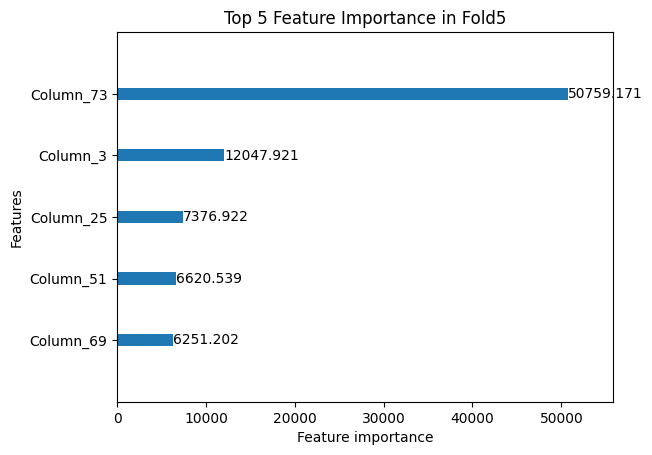


Top 5 features in original feature order: (133, 7, 54, 107, 129)


In [ ]:
# show new feature importance
plot_feature_importance(gbm_remove_least_60, 5)

# Map Top 5 features into the original feature order
print(f'\nTop 5 features in original feature order: {reduced_indices[73], reduced_indices[3], reduced_indices[25], reduced_indices[51], reduced_indices[69]}')